# 4-Modelling

This section will aim to flag loans that are most probable to be late by making prediction on loan features.

Let's start by importing the necessary modules and libraries

In [29]:
#data manipulation tools
import pandas as pd
import numpy as np

#visulisation tools
import matplotlib.pyplot as plt
import seaborn as sns


#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


#cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#preprocesssing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#pipeline importing
from sklearn.pipeline import Pipeline

#model analysis
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#pickle to store our final models
import pickle


sns.set()

Let's load our data

In [2]:
#loading the data types saved from our wrangling
with open("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\notebooks\\2-wrangling\\data_types.pkl", 'rb') as f:
    data_types = pickle.load(f)

In [3]:
#loading training features
X_train_0=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\X_train_new.csv", low_memory=False, index_col=0, dtype=data_types)

C:\Users\yfawz\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
#loading testing features
X_test_0=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\X_test_new.csv",low_memory=False, index_col=0, dtype=data_types)

In [5]:
#loading target variables
y_train_0=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\y_train_new.csv", low_memory=False, index_col=0)
y_test_0=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\y_test_new.csv", low_memory=False, index_col=0)

In [6]:
#loading feature descriptions
eature_desc=pd.read_excel("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\raw\\LCDataDictionary.xlsx")

We already split the data into a training and testing split in the wrangling section, let's now split the training set into a new training set and a validation set using train test split.

In [7]:
#splitting the training set into a validation and training set
X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(X_train_0, 
                                                          y_train_0,
                                                          test_size=0.25,
                                                          stratify=y_train_0)

In [8]:
#resetting the indexes of the target variables
X_train_0=X_train_n.reset_index(drop=True)
X_val_0=X_val_n.reset_index(drop=True)

#resetting the indexes of the features
y_train_0=y_train_n.reset_index(drop=True)
y_val_0=y_val_n.reset_index(drop=True)

Some columns may be 'cheating' and letting our data know that a loan is bad, let's double check the column names and see what stands out.

In [9]:
list(X_train_0.columns)

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',


In [10]:
#initiate a list to drop columns names
to_be_dropped=[]

In [11]:
feature_desc[feature_desc['LoanStatNew']=='recoveries']['Description'].values

array(['post charge off gross recovery'], dtype=object)

We see that recoveries is not a good column to use as this indicates whether the creditor is using a third party to recover the late loans, but let's confrim the number of bad loans with recoveries.

In [12]:
y_train_0.loc[X_train_0[X_train_0['recoveries']>0].index].loan_status.value_counts()

bad    99745
Name: loan_status, dtype: int64

We see that all those with recoveries are bad loans. So it will be dropped along with the associate recovery fee.

In [13]:
to_be_dropped.append('recoveries')
to_be_dropped.append('collection_recovery_fee')

Last payment date will also be removed as this might indicate a bad loan.

In [14]:
to_be_dropped.append('last_pymnt_d')

In [15]:
#dropping the columns from all sets
X_train = X_train_0.drop(to_be_dropped,axis=1)
X_val = X_val_0.drop(to_be_dropped,axis=1)
X_test = X_test_0.drop(to_be_dropped,axis=1)

In [16]:
print('The percentage of bad loans is {}% out of all loans in our training set'.format(np.round((y_train_0.loan_status=='bad').sum()*100/len(y_train_0))))

The percentage of bad loans is 13.0% out of all loans in our training set


The data has around 2,000,000 rows. The current system has 8GB of RAM so running models will be very slow. In this case we will use a sample of the data(60,000 observation) for the training set.

In [17]:
#features
X_train_reduced=X_train.loc[:60000]
X_val_reduced=X_val.loc[:40000]
X_test_reduced=X_test.loc[:20000]

In [18]:
#target variable
y_train_reduced=y_train_0.loc[:60000]
y_val_reduced=y_val_0.loc[:40000]
y_test_reduced=y_test_0.loc[:20000]

Let's setup our arrays for modelling.

The first set will be used to develop a simple model by using only numeric variables and dropping categorical. As seen below.

For the target variable,
- 1 will represent bad loans
- 0 will represent good loans

In [19]:
#create a list of all categorical columns to drop in modelling 
cat_cols=X_train_reduced.select_dtypes(include=['object']).columns

#set up initial training features
y_train = pd.get_dummies(y_train_reduced,).loan_status_bad
X_train_1 = X_train_reduced.drop(cat_cols, axis=1)

In [20]:
#set up initial validation features
y_val = pd.get_dummies(y_val_reduced).loan_status_bad
X_val_1 = X_val_reduced.drop(cat_cols, axis=1)

In [21]:
#set up initial testing features
y_test = pd.get_dummies(y_test_reduced).loan_status_bad
X_test_1 = X_test_reduced.drop(cat_cols, axis=1).values

The second set will be used to introduce categorical variable and transfroming them into numerical variable using the get dummies method.

In [22]:
#set up the second set of training features which include categrocial features
X_train_2 = pd.get_dummies(X_train_reduced, drop_first=True)

In [23]:
#set up the second set of training features which include categrocial features
X_val_2 = pd.get_dummies(X_val_reduced, drop_first=True)

In [24]:
#set up the second set of testing features which include categrocial features
X_test_2 = pd.get_dummies(X_test_reduced, drop_first=True)

In [25]:
print("Reduced shape of training data is {}".format(X_train_2.shape[1]))
print("Reduced shape of testin data is {}".format(X_test_2.shape[1]))

Reduced shape of training data is 1164
Reduced shape of testin data is 1052


We that our training data has values not containined in the testing data. There might be also the possibility of values in the testing set not being in the training set. We have to deal with them such that we have an equal number of features.

In [26]:
# Get missing columns in the training test
missing_cols = set(X_train_2.columns) - set(X_test_2.columns)
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test_2[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test_2 = X_test_2[X_train_2.columns]

In [27]:
# Get missing columns in the training test
missing_cols = set(X_train_2.columns) - set(X_val_2.columns)
# Add a missing column in validation set with default value equal to 0
for c in missing_cols:
    X_val_2[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_val_2 = X_val_2[X_train_2.columns]

In [28]:
print("Reduced shape of training data is {}".format(X_train_2.shape[1]))
print("Reduced shape of training data is {}".format(X_test_2.shape[1]))
print("Reduced shape of training data is {}".format(X_val_2.shape[1]))

Reduced shape of training data is 1164
Reduced shape of training data is 1164
Reduced shape of training data is 1164


Now we have equal shapes for both the training and testing set.

We can see that our columns have increase by a factor of 10. This will cause issued later on when running the mdoel. When comes the time, we will apply some dimensioanlity reduction techniques in our pipeline to make the data simpler to model.

We will want to use the following models:
    
    1. Logistic Regression
    2. Random Forest 
    3. XG boost

This is a highly imbalanced dataset, so accuracy(% of correct predictions) will not be sufficient to assess our models. The Precision and Recall of the bad loans will be of more significance. 

- Precision  is the ratio of (Predicted and Actual True positive(Late Class) predictions) to all positive predictions(False and True positives). A precision of 1.0 means 100% of Predicted predictions are actual positive. This is an important metric here as falsely flagging a loan that will be okay can cause customer dissatisfaction.

- Recall is the ratio of (Predicted and Actual True positive(Late Class) predictions) to all actually postive predictions(TP and FN). A recall of 1.0 means that all bad loans were caught.

There will be a tradeoff between recall and precision but we will aim to maximize precision.

We will assess our models based on the validation sets. Let's build a dataframe to record the results of the recall.

In [98]:
#Set up dataframe to gold validation results
index_sc=['log_reg','rfr','xgb']
val_scores=pd.DataFrame({'recall':np.nan, 'precision':np.nan},index=index_sc)

# 1. Logisitic Regression

## A. Let's start by running our model on only the numerical data with no cross validation.

In [30]:
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train_1,y_train)

# Predict the labels of the test set: y_pred
y_pred_1 = logreg.predict(X_val_1)

C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [34]:
# Compute the recall and precision score of the bad loans
print("Recall is {}".format(recall_score(y_val, y_pred_1)))
print("Precision is {}".format(precision_score(y_val, y_pred_1)))

Recall is 0.8761182419292104
Precision is 0.9995562458398047


We see very good results on the recall with 87% of all bad Actual bad loans being predicted correctly. Meaning 13% of actual bad loans were not caught. But we have a 100% precision meaning those there were no misidentified loans.

## B. Let's now:
1. Use all the features, including the categorical dummy data.
2. Scale the data using MinMaxScaler for all features to have values between 0 and 1.
3. Reduce the dimensionality before running another round of  the model.

### B.1. Let's start with scaling the data such that all the features have a range between 0 and 1.

In [35]:
scaler = MinMaxScaler()
X_rescaled = scaler.fit_transform(X_train_2.values)

In [36]:
X_train_2.values.shape

(60001, 1164)

### B.2. Let's reduce the dimensionality of the data as our we have a lot of features(1229). It will be difficult to choose the number of components but we can ask PCA to let our explained variance to be 100%.

In [37]:
pca = PCA(n_components = 0.99)
pca.fit(X_rescaled)
X_pca = pca.transform(X_rescaled)

In [38]:
print("original shape:   ", X_train_2.shape)
print("transformed shape:", X_pca.shape)

original shape:    (60001, 1164)
transformed shape: (60001, 646)


We see that to reach 99% explained variance, we will need XXX principle components.

### B.3. Let's run our logistic regression model now on the training set.

In [39]:
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_pca,y_train)

C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### B.4. Let's see the results on the validation set.

In [40]:
X_val_rescaled = scaler.transform(X_val_2.values)

In [41]:
X_val_pca = pca.transform(X_val_rescaled)

In [42]:
print("original shape:   ", X_val_2.shape)
print("transformed shape:", X_val_pca.shape)

original shape:    (40001, 1164)
transformed shape: (40001, 646)


In [44]:
y_pred_1_val = logreg.predict(X_val_pca)

# Compute the recall and precision score of the bad loans
print("Recall is {}".format(recall_score(y_val, y_pred_1_val)))
print("Precision is {}".format(precision_score(y_val, y_pred_1_val)))

Recall is 0.8140801244651886
Precision is 0.9988069673109043


We see that using the categorical variables and using PCA actually reduces the recall on the validation set. So we will just use the numerical data to model. 

## C. Let's add some parameter tuning and cross validation into the mix

In [45]:
# Use a five-fold cross validation for all
n_folds=KFold(5)

In [46]:
#prepare our parameters to hyper tune (C and Loss function)
param_dist ={'C':[0.001, 0.01, 0.1, 1, 10],
             'penalty':['l1','l2']}

In [47]:
lr=LogisticRegression()
lr_rscv=RandomizedSearchCV(lr, param_dist, cv=n_folds, n_iter=10)

In [48]:
%%time
lr_rscv.fit(X_train_1, y_train.values)

C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this 

Wall time: 39min 20s


C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=None, re

In [108]:
lr_rscv.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
y_pred_lr = lr_rscv.predict(X_val_1)

# Compute the recall and precision score of the bad loans
print("Recall is {}".format(recall_score(y_val, y_pred_lr)))
print("Precision is {}".format(precision_score(y_val, y_pred_lr)))

Recall is 0.8761182419292104
Precision is 0.9995562458398047


In [101]:
val_scores.loc['log_reg'].recall=np.round(recall_score(y_val, y_pred_lr),2)
val_scores.loc['log_reg'].precision=np.round(precision_score(y_val, y_pred_lr),2)

# 2. Random Forest

In [92]:
rfr=RandomForestClassifier()

In [81]:
param_dist ={'bootstrap': [True, False],
             'max_depth': np.geomspace(1, 100, 20, dtype=int),
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': np.geomspace(2, 2000, 30, dtype=int)}

In [82]:
rfr_rscv=RandomizedSearchCV(rfr, param_dist, cv=n_folds, n_iter=200)

In [83]:
%%time
rfr_rscv.fit(X_train_1[:10000], y_train[:10000].values)

Wall time: 2h 6min 23s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction...
                                        'max_depth': array([  1,   1,   1,

In [127]:
rfr_rscv.best_params_

{'n_estimators': 56,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 29,
 'bootstrap': False}

In [84]:
y_pred_rfr = rfr_rscv.predict(X_val_1)


# Compute the recall and precision score of the bad loans
print("Recall is {}".format(recall_score(y_val, y_pred_rfr)))
print("Precision is {}".format(precision_score(y_val, y_pred_rfr)))

Recall is 0.7835472578763127
Precision is 0.999008182494421


In [104]:
val_scores.loc['rfr'].recall=np.round(recall_score(y_val, y_pred_rfr),2)
val_scores.loc['rfr'].precision=np.round(precision_score(y_val, y_pred_rfr),2)

# 3. XG Boost 

In [93]:
xgb_1 = xgb.XGBClassifier(booster='gbtree',
        objective='binary:logistic')
param_dist = {'n_estimators': np.geomspace(2, 2000, 30, dtype=int),
              'max_features': list(np.arange(2,400,10)),
              'max_depth': list(np.geomspace(1, 100, 20, dtype=int)),
              "subsample":list(np.geomspace(0.001,0.99,20)),
              "learning_rate": list(np.geomspace(0.001, 1, 50)),
              "colsample_bynode": list(np.arange(0, 1, 0.1)) 
       }

In [94]:
xgb_rscv=RandomizedSearchCV(xgb_1, param_dist, cv=n_folds, n_iter=200)

In [95]:
%%time
xgb_rscv.fit(X_train_1[:30000], y_train[:30000].values)

Wall time: 2h 14min 58s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           object...
                                                      0.008830596919378026,
                                                      0.012695653818639529,
                                                      0.018252404379260123,
                  

In [128]:
xgb_rscv.best_params_

{'subsample': 0.99,
 'n_estimators': 771,
 'max_features': 22,
 'max_depth': 61,
 'learning_rate': 0.019306977288832496,
 'colsample_bynode': 0.4}

In [96]:
y_pred_xgb = xgb_rscv.predict(X_val_1)

# Compute the recall and precision score of the bad loans
print("Recall is {}".format(recall_score(y_val, y_pred_xgb)))
print("Precision is {}".format(precision_score(y_val, y_pred_xgb)))

Recall is 0.8623103850641773
Precision is 0.9950628366247756


In [106]:
val_scores.loc['xgb'].recall=np.round(recall_score(y_val, y_pred_xgb),2)
val_scores.loc['xgb'].precision=np.round(precision_score(y_val, y_pred_xgb),2)

# Choosing the best model

We can choose the best model byy looking at the recall/precision performance on the validation set.

In [107]:
val_scores

,recall,precision
log_reg,0.88,1.0
rfr,0.78,1.0
xgb,0.86,1.0


In [126]:
lr_rscv.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

We see that the best model achieving the best recall result is logistic regression with l2 penalty. So we will use this model to predict the testing set

# Prediction on the testing set

In [ ]:
final_log_reg=LogisticRegression(C=1, penalty='l2', thresholds=)

In [130]:
y_pred_test = lr_rscv.predict(X_test_1)

# Compute the recall and precision score of the bad loans
print("Recall is {}".format(recall_score(y_test, y_pred_test)))
print("Precision is {}".format(precision_score(y_test, y_pred_test)))

Recall is 0.8909803921568628
Precision is 0.9995600527936648


In [132]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17451
           1       1.00      0.89      0.94      2550

    accuracy                           0.99     20001
   macro avg       0.99      0.95      0.97     20001
weighted avg       0.99      0.99      0.99     20001



These results look very good as we can spot 89% of actual bad loans while avoiding misclassification of good loans. 

In [115]:
y_pred_test_prob=lr_rscv.predict_proba(X_test_1)[:,-1]

In [116]:
fpr, tpr, thresholds=roc_curve(y_test,y_pred_test_prob)

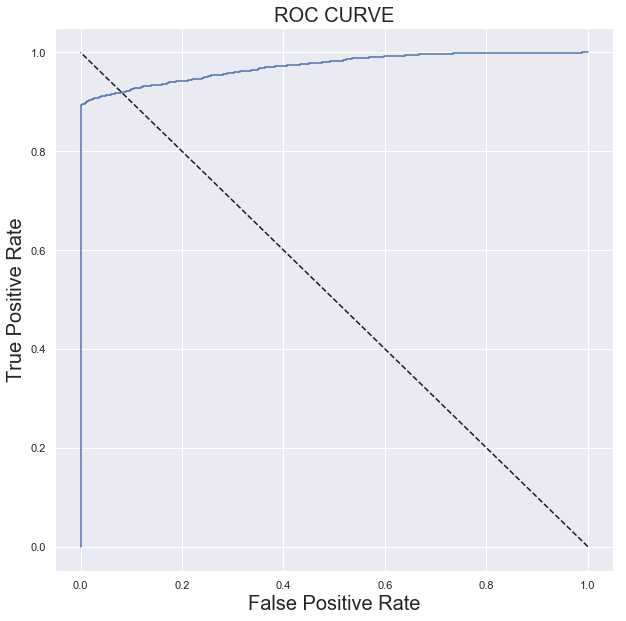

In [129]:
plt.figure(figsize=[10,10])
plt.plot([1,0],[0,1],'k--')
plt.plot(fpr,tpr,label='logistic regression')

plt.title("ROC CURVE", size=20)
plt.xlabel('False Positive Rate',size=20)
plt.ylabel('True Positive Rate',size=20);